<a href="https://colab.research.google.com/github/TakashiSato/colaboratory/blob/master/NonLinearOptimalControl/Algorithm2_4_QuasiNewtonMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import numpy as np
import sympy
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def custom_latex_printer(expr, **options):
    from IPython.display import Math, HTML
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-AMS_CHTML"
    javascript(content="""window.MathJax = {
        tex2jax: {
            inlineMath: [ ['$','$'] ],
            processEscapes: true
        }
        };""")
    javascript(url=url)
    return latex(expr, **options)
init_printing(use_latex="mathjax", latex_printer=custom_latex_printer)

## Robot Arm Class Definition

In [4]:
class DHParameter():
  def __init__(self, link_size):
    self.link_size = link_size
    self.a  = sympy.zeros(self.link_size, 1)
    self.alpha  = sympy.zeros(self.link_size, 1)
    self.d = sympy.zeros(self.link_size, 1)
    self.theta = sympy.zeros(self.link_size, 1)
    for i in range(self.link_size):
      self.a[i], self.alpha[i], self.d[i], self.theta[i] = sympy.var(['a_'+str(i), 'alpha_'+str(i), 'd_' + str(i+1), 'theta_'+str(i+1)])

  def get_symbols(self):
      return self.a, self.alpha, self.d, self.theta

class RobotArm():
  def __init__(self, joint_size):
    self.joint_size = joint_size
    self.link_size = joint_size + 1
    # create symbols
    self.dh = DHParameter(self.link_size)
    a, alpha, d, theta = self.dh.get_symbols()

    # create HT-matrix
    self.T_i = []
    self.T_base = []
    for i in range(self.link_size):
      T = Matrix([[cos(theta[i]), -sin(theta[i]), 0, a[i]], [cos(alpha[i])*sin(theta[i]), cos(alpha[i])*cos(theta[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])], [sin(alpha[i])*sin(theta[i]), sin(alpha[i])*cos(theta[i]), cos(alpha[i]), d[i]*cos(alpha[i])],[0,0,0,1]])
      self.T_i.append(T)
      self.T_base.append(self.T_i[0] if i == 0  else self.T_base[i-1] * self.T_i[i])

  def get_dh_symbols(self):
    return self.dh.get_symbols()

  def set_dh_parameters(self, dh_params):
    for i in range(self.link_size):
        self.T_i[i] = self.T_i[i].subs(dh_params)
        self.T_i[i] = nsimplify(self.T_i[i], tolerance=1e-10,rational=True)
        self.T_base[i] = self.T_i[0] if i == 0  else self.T_base[i-1] * self.T_i[i]
        # self.T_base[i] = self.T_base[i].subs(dh_params)
    
    # compute jacobian
    self.jacobian = sympy.zeros(2, self.joint_size)
    for i in range(2):
      for j in range(self.joint_size):
        self.jacobian[i,j] = diff(self.T_base[-1][i,3], theta[j])

  def forward_kinematics(self, q):
    T_base = []
    if len(q) != self.joint_size:
      print('invalid joint length')
    np.append(q, 0)
    subs_dict = dict(zip(self.dh.theta, q))
    for i in range(self.link_size):
      T_base.append(self.T_base[i].subs(subs_dict))
    return T_base

  def draw(self, q, ax=None, coordinate='xy', style='-bo'):
      T_base = []
      T_base.append(sympy.eye(4,4))
      T_base.extend(self.forward_kinematics(q))
      if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
      for i in range(len(T_base)-1):
        X = [T_base[i][0,3], T_base[i+1][0,3]]
        Y = [T_base[i][1,3], T_base[i+1][1,3]]
        Z = [T_base[i][2,3], T_base[i+1][2,3]]
        if coordinate == 'xy':
          ax.plot(X, Y, style)
          ax.set_xlabel('x')
          ax.set_ylabel('y')
        elif coordinate == 'xz':
          ax.plot(X, Z, style)
          ax.set_xlabel('x')
          ax.set_ylabel('z')
        elif coordinate == 'yz':
          ax.plot(Y, Z, style)
          ax.set_xlabel('y')
          ax.set_ylabel('z')
      ax.plot(0, 0, 'kx', markersize=15)
      ax.set_aspect('equal', 'datalim')

In [5]:
def normalize_angle(angle):
  while angle > np.pi:
    angle -= 2.0*np.pi
  while angle <= -np.pi:
    angle += 2.0*np.pi
  return angle

def to_numpy_array(arr):
  return np.array(arr).astype(np.float64)

In [6]:
class OptimizationResult():
  def __init__(self):
    self.x_symbols = None
    self.f_symbols = None
    self.grad_symbols = None
    self.x_star = []
    self.x0_log = []
    self.eval_log = []

  def record_log(self, x0, eval):
    self.x0_log.append(x0)
    self.eval_log.append(eval)

  def set_result(self, f_symbols, grad_symbols, x_symbols, x_star):
    self.f_symbols = f_symbols
    self.grad_symbols = grad_symbols
    self.x_symbols = x_symbols
    self.x_star = np.array(x_star).astype(np.float64).reshape(1,-1)[0]

In [7]:
# 直線探索
def line_search(f_symbols, x_symbols, x0, s):
  alpha_value = np.linspace(0.01, 2.0*np.pi, 10000)

  alpha = sympy.symbols('alpha')
  x_temp_func  = sympy.lambdify(alpha, x0 + alpha * s, 'numpy')
  f = sympy.lambdify(x_symbols, f_symbols, 'numpy')

  x_temp = x_temp_func(alpha_value)
  eval_value = f(*x_temp)[0]
  min_index = np.argmin(eval_value)
  return alpha_value[min_index], eval_value[min_index]

In [8]:
# 最急降下法
def steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  ret = OptimizationResult()

  # grad_symbols = sympy.tensor.array.derive_by_array(f_symbols, x_symbols)
  grad_symbols = sympy.zeros(1, len(x_symbols))
  for i in range(len(x_symbols)):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])

  ret.record_log(x0, f_symbols.subs(list(zip(x_symbols, x0))))
  for i in range(max_iteration):
    grad =  grad_symbols.subs(list(zip(x_symbols, x0)))
    if grad.norm() < epsilon:
      break
    s = -grad.T
    alpha_star, eval_min =  line_search(f_symbols, x_symbols, x0, s)

    x0 = x0 + alpha_star * s
    for j in range(len(x0)):
      x0[j] = normalize_angle(x0[j])

    ret.record_log(x0, eval_min)

    if i % print_interval == 0:
      print(i, x0, eval_min, grad.norm())
  ret.set_result(f_symbols, grad_symbols, x_symbols, x0)     
  return ret

In [9]:
def conjugate_gradient_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  ret = OptimizationResult()

  # grad_symbols = sympy.tensor.array.derive_by_array(f_symbols, x_symbols)
  grad_symbols = sympy.zeros(1, len(x_symbols))
  for i in range(len(x_symbols)):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])

  ret.record_log(x0, f_symbols.subs(list(zip(x_symbols, x0))))
  n = len(x_symbols)
  k = 0
  x_k = x0
  for i in range(max_iteration):
    if(k == 0):
      grad =  grad_symbols.subs(list(zip(x_symbols, x_k)))
      s_k = d_k = -grad.T
    else:
      s_k = s_kp1
      d_k = d_kp1

    if d_k.norm() < epsilon:
      break

    alpha_k, eval_min =  line_search(f_symbols, x_symbols, x_k, s_k)

    x_k = x_k + alpha_k * s_k
    for j in range(len(x_k)):
      x_k[j] = normalize_angle(x_k[j])

    if k < n-1:
      grad =  grad_symbols.subs(list(zip(x_symbols, x_k)))
      d_kp1 = -grad.T
      # beta_k = d_kp1 * (d_kp1 - d_k) / (d_k.norm() ** 2)
      beta_k = (d_kp1.norm() ** 2) / (d_k.norm() ** 2)
      s_kp1 = d_kp1 + beta_k * s_k
      k += 1
    else:
      k = 0
    ret.record_log(x_k, eval_min)

    if i % print_interval == 0:
      print(i, x_k, eval_min, d_kp1.norm())
  ret.set_result(f_symbols, grad_symbols, x_symbols, x_k)     
  return ret

In [10]:
def newton_raphson_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  def  debug_print(x0, eval_value, grad):
      print('[{0}]\tx0={1}\tf={2},\tgrad={3},\tgrad_norm={4}'.format(
          i, np.round(np.array(x0).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(eval_value).astype(np.float64), 4),
          np.round(np.array(grad).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(grad.norm()).astype(np.float64), 4)))
      
  def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

  ret = OptimizationResult()
  n = len(x_symbols)

  grad_symbols = sympy.zeros(1, n)
  hessian_symbols = sympy.zeros(n, n)
  for i in range(n):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])
    for j in range(n):
      hessian_symbols[i,j] = diff(diff(f_symbols, x_symbols[i]), x_symbols[j])

  # use jacobian
  # grad_symbols = g.T * robot.jacobian
  # hessian_symbols = robot.jacobian.T * robot.jacobian
  
  h = sympy.lambdify(x_symbols, hessian_symbols, 'numpy')

  # 1) initial x0 is given by argument
  for i in range(max_iteration):
    # logging
    eval_value =  f_symbols.subs(list(zip(x_symbols, x0)))
    ret.record_log(x0, eval_value)

    # 2) stop when grad vector norm nearly equal 0
    grad =  grad_symbols.subs(list(zip(x_symbols, x0)))
    if grad.norm() < epsilon:
      break
    if i % print_interval == 0:
      debug_print(x0, eval_value, grad)

    # 3) compute delta x by usin eq.(2.29)
    hessian = hessian_symbols.subs(list(zip(x_symbols, x0)))
    H = hessian + sympy.eye(n, n) * 1e-9
    H_value = h(*(to_numpy_array(x0))).reshape(n, n)
    if not is_pos_def(H_value):
      print("Hessian is not positive definite matrix!")

    dx = -(H.inv() * grad.T)

    # check newton direction
    if (grad * dx)[0] > 0:
      print("Newton direction is not down direction!")
      dx *= -1

    # 3.5) line search
    alpha, _ =  line_search(f_symbols, x_symbols, x0, dx)
    # alpha = 1.0

    # 4) compute x0 := x0 + alpha * dx -> back to step 2)
    x0 = x0 + alpha * dx
    for j in range(len(x0)):
      x0[j] = normalize_angle(x0[j])

  debug_print(x0, eval_value, grad)

  ret.set_result(f_symbols, grad_symbols, x_symbols, x0)     
  return ret

## 具体値計算

In [11]:
# create robot arm
joint_size = 2
robot = RobotArm(joint_size)
a, alpha, d, theta = robot.get_dh_symbols()
robot.set_dh_parameters({
    a[0]: 0,     alpha[0]: 0, d[0]: 0,
    a[1]: 1.0, alpha[1]: 0, d[1]: 0,
    a[2]: 1.0, alpha[2]: 0, d[2]: 0, theta[2]: 0,
})

# joint_size = 5
# robot = RobotArm(joint_size)
# a, alpha, d, theta = robot.get_dh_symbols()
# robot.set_dh_parameters({
#     a[0]: 0,   alpha[0]: 0, d[0]: 0,
#     a[1]: 1.0, alpha[1]: 0, d[1]: 0,
#     a[2]: 1.0, alpha[2]: 0, d[2]: 0,
#     a[3]: 1.0, alpha[3]: 0, d[3]: 0,
#     a[4]: 1.0, alpha[4]: 0, d[4]: 0,
#     a[5]: 1.0, alpha[5]: 0, d[5]: 0, theta[5]: 0,
# })

# joint_size = 7
# robot = RobotArm(joint_size)
# a, alpha, d, theta = robot.get_dh_symbols()
# robot.set_dh_parameters({
#     a[0]: 0, alpha[0]: 0,               d[0]: 0.215,
#     a[1]: 0, alpha[1]: -np.pi/2, d[1]: 0,
#     a[2]: 0, alpha[2]: +np.pi/2, d[2]: 0.300,
#     a[3]: 0, alpha[3]: -np.pi/2,  d[3]: 0,
#     a[4]: 0, alpha[4]: +np.pi/2, d[4]: 0.300,
#     a[5]: 0, alpha[5]: -np.pi/2,  d[5]: 0,
#     a[6]: 0, alpha[6]: +np.pi/2, d[6]: 0.170,
#     a[7]: 0, alpha[7]: 0,                d[7]: 0, theta[7]: 0,
# })

In [12]:
def plot_result(result):
  fig, axes = plt.subplots(1, 4,  figsize=(32,8))

  # plot robot link movement
  ax = axes[0]
  for x_ in result.x0_log:
    robot.draw(x_, ax=ax, coordinate='xy', style='--bo')
  robot.draw(result.x0_log[0], ax=ax, style='-go')
  robot.draw(result.x_star, ax=ax, style='-ro')
  ax.plot(xd[0], xd[1], 'r*', markersize=14)

  # plot eval value log
  ax = axes[1]
  ax.plot(result.eval_log, '-bo')
  ax.set_xlabel('step')
  ax.set_ylabel('eval value')

  # plot gradient norm value log
  ax = axes[2]
  grad = sympy.lambdify(result.x_symbols, result.grad_symbols, 'numpy')
  x0_ = to_numpy_array(result.x0_log).transpose()
  grad_value = grad(*x0_)
  ax.plot(np.linalg.norm(grad_value, axis=1).reshape(-1), '-bo')
  ax.set_xlabel('step')
  ax.set_ylabel('gradient norm value')

  # plot gradient log
  ax = axes[3]
  t1 = t2 = np.linspace(-np.pi, np.pi, 100)
  f_func = sympy.lambdify(result.x_symbols, result.f_symbols, 'numpy') 
  grad_func = sympy.lambdify(result.x_symbols, result.grad_symbols, 'numpy') 
  X, Y = np.meshgrid(t1, t2)
  Z = f_func(X, Y)
  cont = ax.contour(X, Y, Z, 20)
  cont.clabel(fmt='%1.1f', fontsize=14)
  x0_ = []
  y0_ = []
  for x0 in result.x0_log:
    x0_.append(x0[0])
    y0_.append(x0[1])
  ax.plot(x0_, y0_, '--o')
  ax.plot(x0_[-1], y0_[-1], 'r*')
  ax.set_title('evaluation function')
  pp = ax.pcolormesh(X,Y,Z,cmap='cool')
  pp=fig.colorbar (pp, orientation="vertical")

  # plot gradient 3d
  fig_3d, ax_3d = plt.subplots(1, 1,  figsize=(8,8))
  ax = Axes3D(fig_3d)
  # ax.plot_surface(X, Y, Z)
  z0_ = np.array(result.eval_log)
  ax.plot_wireframe(X, Y, Z, linewidth=0.1)
  ax.contour(X, Y, Z)
  ax.plot(x0_, y0_, z0_, '-ro', markersize=5)

In [1]:
def quasi_newton_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100, print_interval=10):
  def  debug_print(x0, eval_value, grad):
      print('[{0}]\tx0={1}\tf={2},\tgrad={3},\tgrad_norm={4}'.format(
          i, np.round(np.array(x0).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(eval_value).astype(np.float64), 4),
          np.round(np.array(grad).astype(np.float64).reshape(1,-1)[0],4),
          np.round(np.array(grad.norm()).astype(np.float64), 4)))
      
  ret = OptimizationResult()
  n = len(x_symbols)

  grad_symbols = sympy.zeros(1, n)
  for i in range(n):
    grad_symbols[i] = diff(f_symbols, x_symbols[i])
  # use jacobian
  # grad_symbols = g.T * robot.jacobian
  
  x_k = x0
  g_k =  grad_symbols.subs(list(zip(x_symbols, x_k)))
  H_k = sympy.eye(n, n)

  # 1) initial x0 is given by argument
  for i in range(max_iteration):
    # logging
    eval_value =  f_symbols.subs(list(zip(x_symbols, x_k)))
    ret.record_log(x_k, eval_value)

    # 2) stop when grad vector norm nearly equal 0
    if g_k.norm() < epsilon:
      break
    if i % print_interval == 0:
      debug_print(x_k, eval_value, g_k)

    # 3.5) line search
    d_k = -H_k.inv() * g_k.T
    alpha, _ =  line_search(f_symbols, x_symbols, x_k, d_k)
    
    # 4) compute x0 := x0 + alpha * dx -> back to step 2)
    x_kp1 = x_k + alpha * d_k
    for j in range(n):
      x_kp1[j] = normalize_angle(x_kp1[j]) 
    g_kp1 =  grad_symbols.subs(list(zip(x_symbols, x_kp1)))

    # 3) compute delta x by usin eq.(2.29)
    y_k = g_kp1.T - g_k.T
    s_k = x_kp1 - x_k
 
    # BFGS method
    # return (s_k.T * H_k * s_k)
    # H_k = H_k + (y_k * y_k.T) / (y_k.T * s_k)# - (H_k  * s_k * s_k.T * H_k) / (s_k.T * H_k * s_k)
    # print(H_k)
    # np.linalg.inv(H_k)

    # DFP method
    H_k = H_k + (s_k * s_k.T) / (s_k.T * y_k)[0] - (H_k * y_k * y_k.T * H_k) / (y_k.T * H_k * y_k)[0]

    x_k = x_kp1
    g_k = g_kp1

  debug_print(x_k, eval_value, g_k)

  ret.set_result(f_symbols, grad_symbols, x_symbols, x_k)     
  return ret

[0]	x0=[-1.0861 -0.8795]	f=3.5351,	grad=[1.093  1.6488],	grad_norm=1.9782
[7]	x0=[-2.9524 -2.1109]	f=0.0,	grad=[ 0.0005 -0.0003],	grad_norm=0.0006


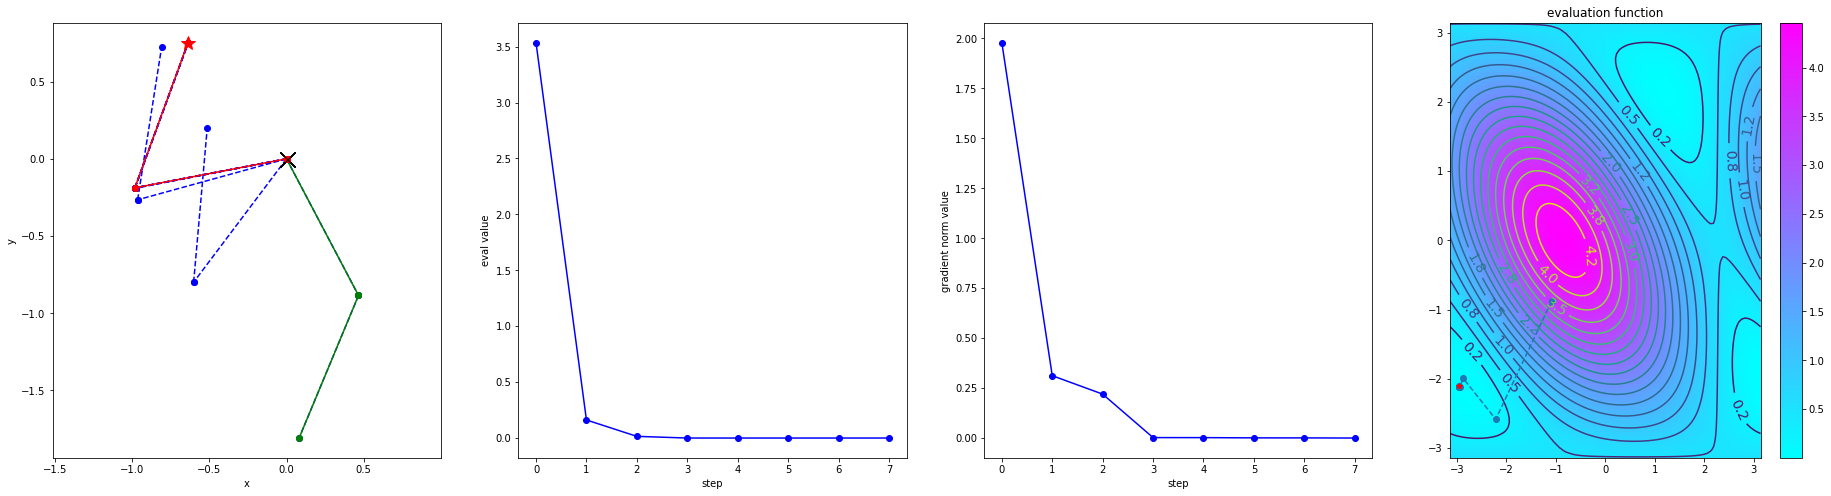

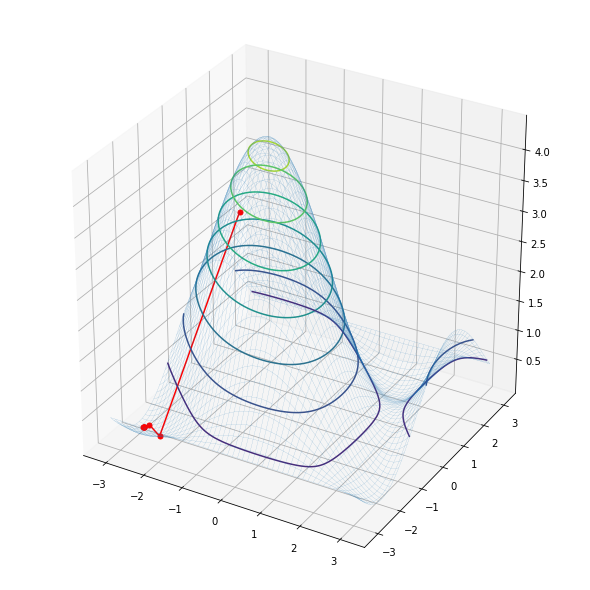

In [16]:
# problem settings
x0 = Matrix(np.random.uniform(-np.pi, np.pi, joint_size))
xd = Matrix(np.random.uniform(-1, 1, 2))
ee_pose = robot.T_base[-1][0:2,3]

g = Matrix(ee_pose - xd)
f_symbols = Matrix(1/2*g.T*g )[0]
x_symbols = Matrix(theta[0:-1])

# solve problem
# result = steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1)
# result = conjugate_gradient_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1)
# result = newton_raphson_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=1)
result = quasi_newton_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100, print_interval=10)
plot_result(result)

# manipulability = sqrt((robot.jacobian*robot.jacobian.T).det())
# print('manipulability: ', manipulability.subs(list(zip(x_symbols, result.x_star))))